In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
import matplotlib.pyplot as plt
import suftware as su

Here we estimate the intrinsic information in Mandy's data using the $\Psi$ and $d\Psi$ values reported in psi_9nt.csv. Using $y = \log \Psi$,  we first estimate $H[y]$ using DEFT. Specifically, we use the mean posterior estimate of $H[y]$, along with its RMSD uncertainty, computed using posterior sampling of field-theoretic density estimates.

Then, based on the $d\Psi$ values reproted in psi_9nt.csv, we compute $H[y|x]$ by assuming that each $y$ value has Gaussian uncertainty quantified by standard deviation $dy = d\Psi/\Psi$. 
For a Gaussian distribution with standard deviation $\sigma$, entropy in bits is given by:

$$ H = \frac{1}{2} \log_2(2 \pi e dy^2) ~~~ \Leftrightarrow ~~~ dy = \frac{2^H}{\sqrt{2 \pi e}} $$

Therefore, for each datapoint $i=1,\ldots,N$, we compute 

$h_i = \frac{1}{2} \log_2(2 \pi e dy_i^2)$

We then estimate the entropy as the mean plus-or-minus the SEM of these values:

$H[y|x] = \mathrm{mean}(h_i) \pm \mathrm{std}(h_i)/\sqrt{N}.$

Finally we compute the intrinsic information in the data using

$$ I[y;x] = H[y] - H[y|x],$$

which has a corresponding uncertainty

$$ dI[y;x] = \sqrt{dH[y]^2 + dH[y|x]^2}.$$

My biggest concern with these calculations are the values of $d\Psi$ reported in Mandy's experiment. These would probably be more accurate if they were computed using bootstrap resampling of barcodes rather than averaging across replicates. I've used this before with Andalus's data and it seems to work well. We should do this for Mandy's data, rather than used the published values. But this is a relatively minor issue at this point.

The next thing on the list of to-dos is to extimate the mutual information $I[y;\phi] = I[y;\hat{y}]$ using the noise models inferred by MAVE-NN. I expect we should be able to provide both upper- and lower- bounds on this information value. 

We should compare these calculations of $I[y;\phi]$ to that produced by the Kraskov estimator. Would be interest to see how this noise-model-based MI inference compares to nonparametric methods.

In [2]:
df = pd.read_csv('psi_9nt.csv')
df.head()

,seq,brca2_9nt,brca2_9nt_stderr,ikbkap_9nt,ikbkap_9nt_stderr,smn1_9nt,smn1_9nt_stderr
0,AAAGCAAAA,0.373522,0.095217,0.080039,0.081333,0.227001,0.082164
1,AAAGCAAAC,0.688386,0.063575,0.061021,0.018316,0.522138,0.017503
2,AAAGCAAAG,0.756357,0.481555,0.045032,0.023374,0.210907,0.170688
3,AAAGCAAAU,0.443014,0.127961,0.071423,0.028762,0.232645,0.044371
4,AAAGCAACA,0.548363,0.140963,0.100128,0.071551,0.362139,0.127696


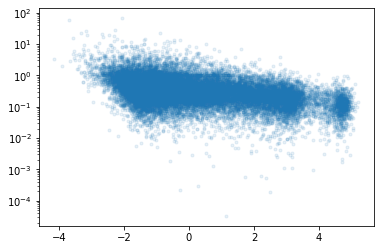

In [3]:
locus = 'smn1'
y_col = f'{locus}_9nt'
dy_col = f'{locus}_9nt_stderr'

#y_col = 'brca2_9nt'
#dy_col = 'brca2_9nt_stderr'
df = df[[y_col, dy_col]].dropna()
psi = df[y_col].values
dpsi = df[dy_col].values
ix = (psi > 0) & (dpsi > 0)
psi = psi[ix]
dpsi = dpsi[ix]
y = np.log(psi)
dy = dpsi/psi
plt.semilogy(y,dy,'.',alpha=.1)

H[y] = +2.6861 +- 0.0062 bits


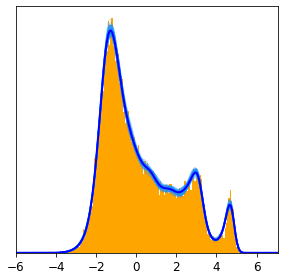

,entropy,mean,variance,skewness,kurtosis
star,-2.68682,0.23239,3.53236,0.714259,2.53604
histogram,-2.67428,0.232083,3.5313,0.714212,2.53572
maxent,-2.95636,0.232083,3.5313,0.00993614,2.93564
posterior mean,-2.68614,0.232664,3.53304,0.714691,2.53586
posterior RMSD,0.00622618,0.012829,0.0285631,0.0116106,0.0246011


In [4]:
# Use DEFT to compute H[y]
p = su.DensityEstimator(y, num_grid_points=200)
stats_df = p.get_stats()
H_y = -stats_df.loc['posterior mean','entropy'] ## DEFT REPORTS NEGATIVE ENTROPY! NEEDS FIXING.
dH_y = stats_df.loc['posterior RMSD','entropy']
print(f'H[y] = {H_y:+.4f} +- {dH_y:.4f} bits')
p.plot()
stats_df

In [5]:
# Double-check that this is right
x_min = p.bounding_box[0]
x_max = p.bounding_box[1]
G = 1000
x_grid = np.linspace(x_min, x_max, G)
dx = x_grid[1]-x_grid[0]
p_grid = p.density_func(x_grid)
H_y_check = -np.sum(dx*p_grid * np.log2(p_grid))
print(f'From manual calculation, H[y] = {H_y_check:.4f}')

From manual calculation, H[y] = 2.6868


In [6]:
# Compute the sequence-conditioned entropy
e = np.exp(1)
pi = np.pi
Hs_bits = .5*np.log2(2*pi*e*dy**2)
N = len(Hs_bits)
H_ygx = np.mean(Hs_bits)
dH_ygx = np.std(Hs_bits)/np.sqrt(N)
print(f'H[y|x] = {H_ygx:.4f} +- {dH_ygx:.4f} bits')

H[y|x] = 0.3159 +- 0.0092 bits


Effective dy is = 0.3012
If all points had this dy value, entropy would be 0.3159.


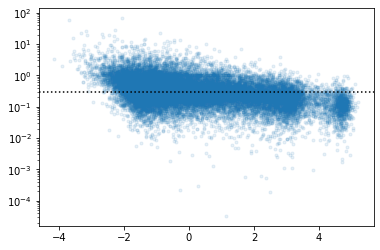

In [7]:
# Compute the effective dy from this entropy
dy_eff = (2**H_ygx)/np.sqrt(2*pi*e)
print(f'Effective dy is = {dy_eff:.4f}')
H_eff = 0.5*np.log2(2*pi*e*dy_eff**2)
print(f'If all points had this dy value, entropy would be {H_eff:.4f}.')
plt.semilogy(y,dy,'.',alpha=.1)
plt.axhline(dy_eff, color='k', linestyle=':')

In [8]:
# Finally, compute intrinsic information in experiment
I_y_x = H_y - H_ygx
dI_y_x = np.sqrt(dH_y**2 + dH_ygx**2)
print(f'I[y;x] = {I_y_x:.4f} +- {dI_y_x:.4f} bits')

I[y;x] = 2.3702 +- 0.0111 bits


In [9]:
# Load data
df = pd.read_csv('psi_9nt.csv')

# Get useful consts
e = np.exp(1)
pi = np.pi

for locus in ['brca2','smn1','ikbkap']:

    # Provide feedback
    print(f'\n{locus}:')
    
    # Extract psi values from dataframe
    y_col = f'{locus}_9nt'
    dy_col = f'{locus}_9nt_stderr'
    tmp_df = df[[y_col, dy_col]].copy().dropna()
    psi = tmp_df[y_col].values
    dpsi = tmp_df[dy_col].values
    ix = (psi > 0) & (dpsi > 0)
    psi = psi[ix]
    dpsi = dpsi[ix]
    
    # Compute y and dy values to do the estimation on
    y = np.log(psi)
    dy = dpsi/psi

    # Use DEFT to compute H[y]
    p = su.DensityEstimator(y, num_grid_points=200)
    stats_df = p.get_stats()
    H_y = -stats_df.loc['posterior mean','entropy']
    dH_y = stats_df.loc['posterior RMSD','entropy']
    print(f'H[y]   = {H_y:+.4f} +- {dH_y:.4f} bits')
    
    # Use the formula for Gaussian entropy to compute H[y|x]
    Hs_bits = .5*np.log2(2*pi*e*dy**2)
    N = len(Hs_bits)
    H_ygx = np.mean(Hs_bits)
    dH_ygx = np.std(Hs_bits, ddof=1)/np.sqrt(N)  # Note that need to specify 1 DOF, not that it matters much.
    print(f'H[y|x] = {H_ygx:+.4f} +- {dH_ygx:.4f} bits')
    
    # Finally, compute intrinsic information in experiment
    I_y_x = H_y - H_ygx
    dI_y_x = np.sqrt(dH_y**2 + dH_ygx**2)
    print(f'I[y;x] = {I_y_x:+.4f} +- {dI_y_x:.4f} bits')


brca2:
H[y]   = +1.2215 +- 0.0116 bits
H[y|x] = -0.4608 +- 0.0099 bits
I[y;x] = +1.6823 +- 0.0152 bits

smn1:
H[y]   = +2.6868 +- 0.0058 bits
H[y|x] = +0.3159 +- 0.0092 bits
I[y;x] = +2.3708 +- 0.0109 bits

ikbkap:
H[y]   = +1.6501 +- 0.0076 bits
H[y|x] = +1.1318 +- 0.0112 bits
I[y;x] = +0.5183 +- 0.0136 bits
